# Robyn: Marketing Mix Modeling in Python

Welcome to Robyn, a powerful Marketing Mix Modeling (MMM) tool developed by Meta. This notebook demonstrates how to use Robyn to build and analyze marketing mix models.

This notebook demonstrates the basic workflow of using Robyn for Marketing Mix Modeling. For your own analysis:

1. Replace the sample data with your marketing data
2. Adjust the model parameters based on your business context
3. Validate results against your business knowledge 
4. Use the optimization insights to guide marketing budget allocation

For more information, visit the [Robyn documentation](https://github.com/facebookexperimental/Robyn).

## Installation

Install Robyn using pip:

- pip install robynpy


## Import Required Libraries


In [1]:
import pandas as pd
from robyn.robyn import Robyn
from robyn.data.entities.mmmdata import MMMData
from robyn.data.entities.holidays_data import HolidaysData
from robyn.data.entities.hyperparameters import Hyperparameters, ChannelHyperparameters
from robyn.data.entities.enums import AdstockType, DependentVarType

2024-12-06 19:25:28,648 - robyn - INFO - Logging is set up to console only.
/Users/yijuilee/robynpy_release_reviews/robynvenv_py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load simulated data.

For this demonstration, we'll use simulated data included with Robyn. In practice, you can replace this with your own marketing data.

In [2]:
# Load simulated weekly data
dt_simulated_weekly = pd.read_csv("resources/dt_simulated_weekly.csv")

# Load holidays data (used for seasonality modeling)
dt_prophet_holidays = pd.read_csv("resources/dt_prophet_holidays.csv")

## Initialize Robyn

## 1. Configure MMM Data

Define the model specification including dependent variables, independent variables, and analysis window. Here's what each parameter means:

### Key Components:
- `dep_var`: Your target metric (e.g., "revenue", "conversions")
- `dep_var_type`: Type of dependent variable ("revenue" for ROI or "conversion" for CPA)
- `date_var`: Column name containing dates
- `window_start/end`: Analysis time period

### Variable Types:
- `paid_media_spends`: Columns containing media spend data (e.g., TV, Facebook, Search)
- `paid_media_vars`: Media exposure metrics (impressions, clicks) in same order as spends
- `context_vars`: External factors (e.g., competitor activities, events, seasonality)
- `organic_vars`: Marketing activities without direct spend (e.g., email, social posts)

Example configuration:

In [3]:
mmm_data_spec = MMMData.MMMDataSpec(
    dep_var="revenue",  # Target variable
    dep_var_type="revenue",  # Type: "revenue" or "conversion"
    date_var="DATE",  # Date column name
    context_vars=["competitor_sales_B", "events"],  # External factors
    paid_media_spends=[
        "tv_S",
        "ooh_S",
        "print_S",
        "facebook_S",
        "search_S",
    ],  # Media spend columns
    paid_media_vars=[
        "tv_S",
        "ooh_S",
        "print_S",
        "facebook_I",
        "search_clicks_P",
    ],  # Media metrics
    organic_vars=["newsletter"],  # Non-paid marketing activities
    window_start="2016-01-01",  # Analysis start date
    window_end="2018-12-31",  # Analysis end date
)

mmm_data = MMMData(data=dt_simulated_weekly, mmmdata_spec=mmm_data_spec)

## Configure Holiday Data

Holiday data helps capture seasonality and special events in your model. The HolidaysData configuration includes:

### Components:
- `dt_holidays`: DataFrame containing holiday/events data
- `prophet_vars`: Time components to model:
  - "trend": Long-term trend
  - "season": Seasonal patterns
  - "holiday": Holiday/event effects
- `prophet_country`: Country code for built-in holidays (e.g., "DE" for Germany)
- `prophet_signs`: Effect direction for each prophet_var:
  - "default": Let the model determine direction
  - "positive": Force positive effect
  - "negative": Force negative effect

Note: You can add custom events (school breaks, promotional periods, etc.) to the holidays data.

In [4]:
holidays_data = HolidaysData(
    dt_holidays=dt_prophet_holidays,
    prophet_vars=["trend", "season", "holiday"],
    prophet_country="DE",
    prophet_signs=["default", "default", "default"],
)

## Configure Hyperparameters

Hyperparameters control how media effects are modeled. Each channel requires three key parameters:

### Media Channel Parameters:
- `alphas`: Controls saturation curve shape [0.5, 3]
  - Lower values (0.5-1): More diminishing returns
  - Higher values (2-3): More S-shaped response
  
- `gammas`: Controls saturation curve inflection point [0.3, 1]
  - Lower values: Earlier diminishing returns
  - Higher values: Later diminishing returns

- `thetas`: Controls adstock decay rate [0, 0.8]
  - Lower values (0-0.2): Fast decay (e.g., Search, Social)
  - Medium values (0.1-0.4): Medium decay (e.g., Print, OOH)
  - Higher values (0.3-0.8): Slow decay (e.g., TV)

### Global Parameters:
- `adstock`: Type of carryover effect modeling
  - "geometric": Fixed decay rate
  - "weibull_cdf": Flexible decay with cumulative distribution
  - "weibull_pdf": Flexible decay with potential peak delay

- `lambda_`: Ridge regression regularization [0, 1]
- `train_size`: Proportion of data for training [0.5, 0.8]

In [5]:
hyperparameters = Hyperparameters(
    hyperparameters={
        "facebook_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0, 0.3],
        ),
        "print_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
        "tv_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.3, 0.8],
        ),
        "search_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0, 0.3],
        ),
        "ooh_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
        "newsletter": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
    },
    adstock=AdstockType.GEOMETRIC,
    lambda_=[0, 1],
    train_size=[0.5, 0.8],
)

### 4. Initialize model and run feature engineering

In [6]:
robyn = Robyn(working_dir="output")
robyn.initialize(
    mmm_data=mmm_data,
    holidays_data=holidays_data,
    hyperparameters=hyperparameters,
)

INFO: Initialized Robyn in output
2024-12-06 19:25:30,377 - robyn.robyn - INFO - Initialized Robyn in output
INFO: Validating input data
2024-12-06 19:25:30,377 - robyn.robyn - INFO - Validating input data
2024-12-06 19:25:30,378 - robyn.data.validation.mmmdata_validation - INFO - Starting complete MMMData validation
2024-12-06 19:25:30,379 - robyn.data.validation.mmmdata_validation - INFO - Missing and infinite value check passed successfully
2024-12-06 19:25:30,381 - robyn.data.validation.mmmdata_validation - INFO - No-variance check passed successfully
2024-12-06 19:25:30,381 - robyn.data.validation.mmmdata_validation - INFO - Variable names validation passed successfully
2024-12-06 19:25:30,381 - robyn.data.validation.mmmdata_validation - INFO - Date variable validation passed successfully
2024-12-06 19:25:30,382 - robyn.data.validation.mmmdata_validation - INFO - Dependent variable validation passed successfully
2024-12-06 19:25:30,382 - robyn.data.validation.mmmdata_validation - 

## Feature Engineering

INFO: Performing feature engineering
2024-12-06 19:25:30,401 - robyn.robyn - INFO - Performing feature engineering
2024-12-06 19:25:30,401 - robyn.modeling.feature_engineering - INFO - Starting feature engineering process
2024-12-06 19:25:30,403 - robyn.modeling.feature_engineering - INFO - Starting Prophet decomposition
2024-12-06 19:25:30,403 - robyn.modeling.feature_engineering - INFO - Starting Prophet decomposition
/Users/yijuilee/robynpy_release_reviews/robynvenv_py3.10/lib/python3.10/site-packages/prophet/forecaster.py:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
2024-12-06 19:25:31,049 - cmdstanpy - DEBUG - input tempfile: /var/folders/gm/g5cpl7110m96nfd1qr1xwnwc0000gn/T/tmpa

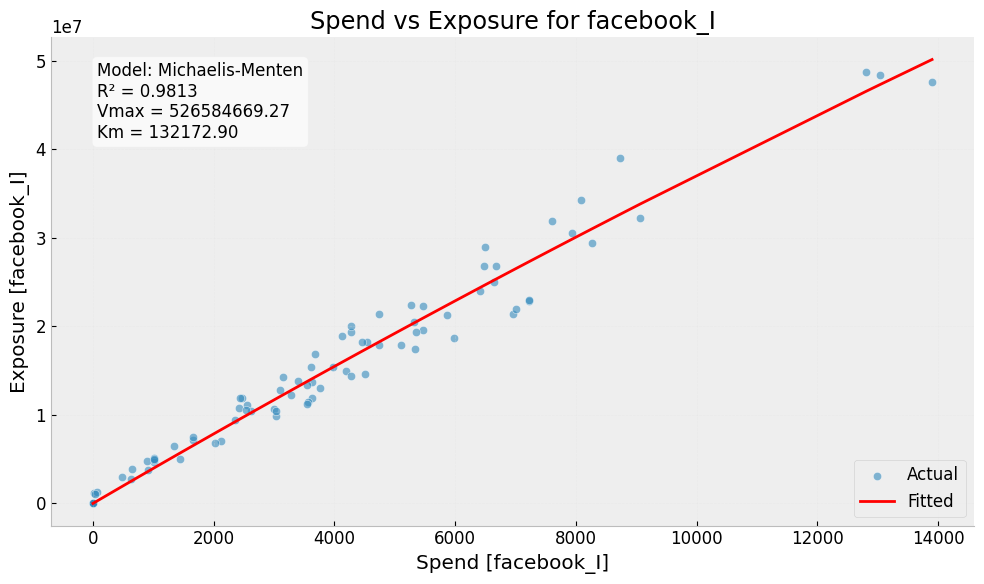

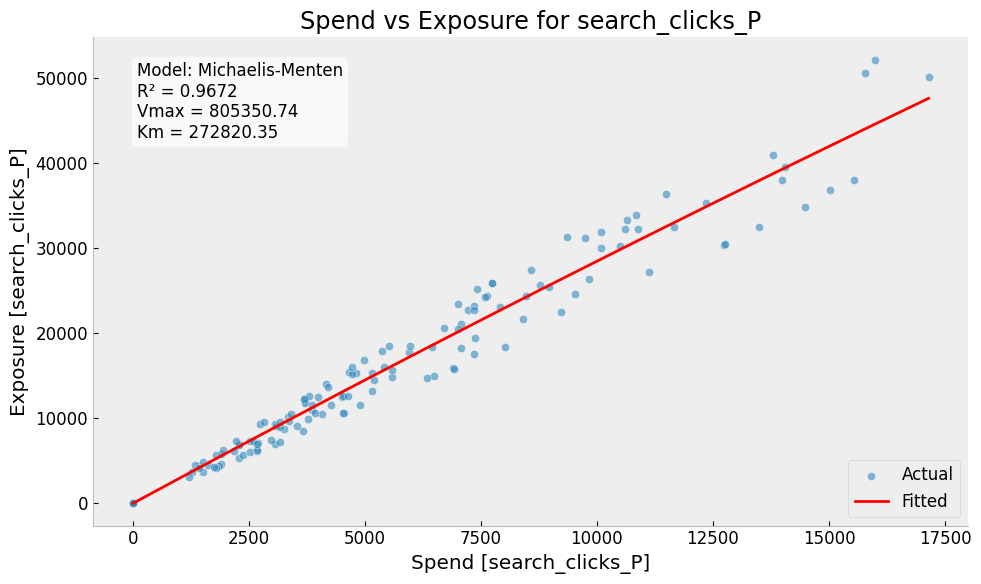

In [7]:
%matplotlib inline
# Run feature engineering
robyn.feature_engineering();

## Model Training

### Training Configuration:
- `trials`: Number of parallel optimization trials (e.g., 5)
- `iterations`: Optimization iterations per trial (e.g., 2000)
- `ts_validation`: Whether to use time-series validation
- `cores`: Number of CPU cores to use for parallel processing
- `nevergrad_algo`: Optimization algorithm (TWO_POINTS_DE recommended)
- `model_name`: Model type (RIDGE regression recommended)

Parameters:
- `add_penalty_factor`: Additional regularization for stability
- `rssd_zero_penalty`: Penalize unrealistic zero contributions
- `intercept`: Include intercept term
- `intercept_sign`: Control intercept direction

In [8]:
from robyn.modeling.entities.enums import Models, NevergradAlgorithm
from robyn.modeling.entities.modelrun_trials_config import TrialsConfig

trials_config = TrialsConfig(iterations=54, trials=5)

robyn.train_models(
    trials_config=trials_config,
    ts_validation=True,
    add_penalty_factor=False,
    rssd_zero_penalty=True,
    cores=8,
    nevergrad_algo=NevergradAlgorithm.TWO_POINTS_DE,
    model_name=Models.RIDGE,
)

INFO: Training models
2024-12-06 19:25:31,677 - robyn.robyn - INFO - Training models
2024-12-06 19:25:31,679 - robyn.modeling.base_model_executor - INFO - Initializing BaseModelExecutor
2024-12-06 19:25:31,680 - robyn.modeling.model_executor - INFO - Starting model execution with model_name=Models.RIDGE
2024-12-06 19:25:31,680 - robyn.modeling.base_model_executor - INFO - Input validation successful
2024-12-06 19:25:31,680 - robyn.modeling.base_model_executor - INFO - Preparing hyperparameters
2024-12-06 19:25:31,681 - robyn.modeling.base_model_executor - INFO - Completed hyperparameter preparation with 20 parameters to optimize
2024-12-06 19:25:31,681 - robyn.modeling.model_executor - INFO - Initializing Ridge model builder
2024-12-06 19:25:31,681 - robyn.modeling.model_executor - INFO - Building models with configured parameters
2024-12-06 19:25:31,681 - robyn.modeling.ridge.ridge_data_builder - INFO - Collecting hyperparameters for optimization...
Running trial 1 of total 5 trials: 

## Evaluate Models

After training, we evaluate and cluster models to find stable solutions. The clustering process helps identify groups of models with similar characteristics and performance.

### Clustering Configuration Parameters:

1. `dep_var_type`: Sets the dependent variable type
   - "revenue" for revenue/ROI models
   - "conversion" for conversion/CPA models

2. `cluster_by`: Choose clustering criterion:
   - `ClusterBy.HYPERPARAMETERS`: Group models by similar media parameters
   - `ClusterBy.DECOMPOSITION`: Group by similar channel contributions
   - `ClusterBy.COMBINED`: Use both criteria

3. `max_clusters` and `min_clusters`: Control cluster count
   - `min_clusters=3`: Minimum groups to identify
   - `max_clusters=10`: Maximum groups to consider
   - Balance between too few (oversimplified) and too many (overcomplicated)

4. `weights`: Importance of different clustering criteria [nrmse, decomp, rsq]
   - Default [1.0, 1.0, 1.0] weights all criteria equally
   - Adjust weights to prioritize certain aspects

INFO: Evaluating models
2024-12-06 19:25:48,156 - robyn.robyn - INFO - Evaluating models
2024-12-06 19:25:48 [INFO] Starting Pareto optimization
2024-12-06 19:25:48,159 - robyn.modeling.pareto.data_aggregator - INFO - Starting model data aggregation
2024-12-06 19:25:48 [INFO] Computing Pareto fronts
2024-12-06 19:25:48 [INFO] Pareto front computation completed
2024-12-06 19:25:48 [INFO] Preparing Pareto data
2024-12-06 19:25:48 [INFO] Number of Pareto-optimal solutions found: 219
2024-12-06 19:25:48 [INFO] Selected 9 Pareto-fronts containing 104 candidates
2024-12-06 19:25:48 [INFO] Selected Pareto fronts: 10
2024-12-06 19:25:48 [INFO] Filtering data for selected Pareto fronts...
2024-12-06 19:25:48 [INFO] Pareto data preparation completed
2024-12-06 19:25:48,201 - robyn.modeling.pareto.response_curve - INFO - Calculating response curves for 520 models' media variables...
Processing rows: 100%|██████████| 520/520 [00:05<00:00, 101.64it/s]
2024-12-06 19:25:54,081 - robyn.modeling.pareto

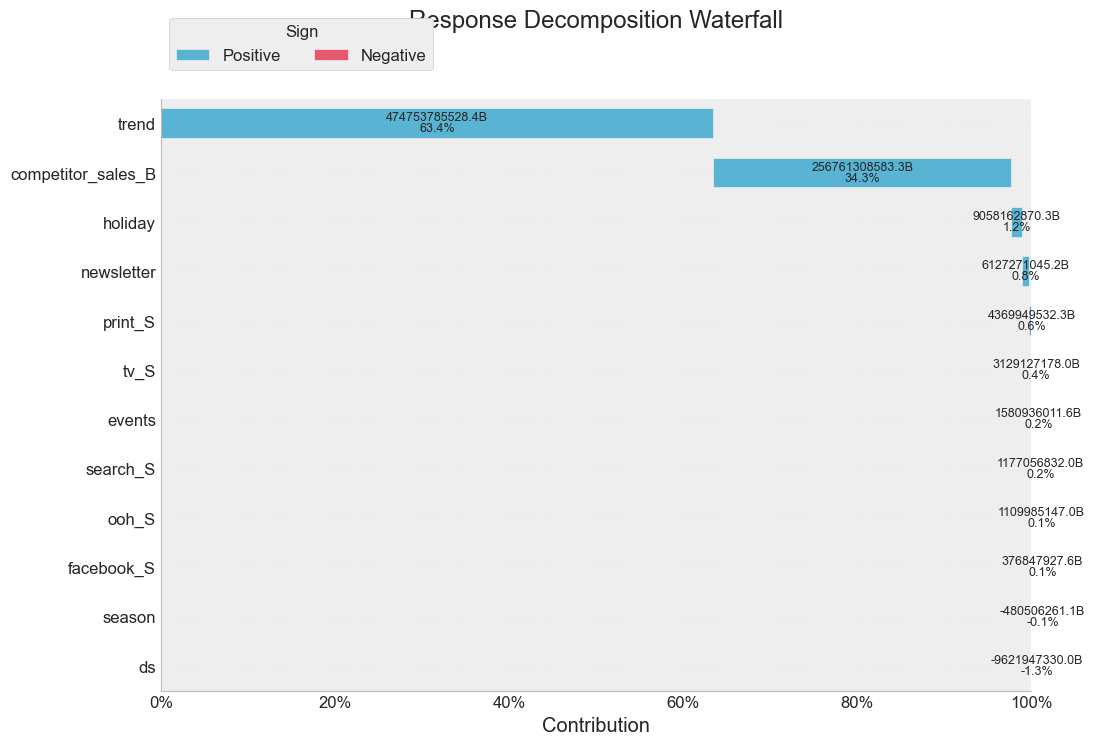

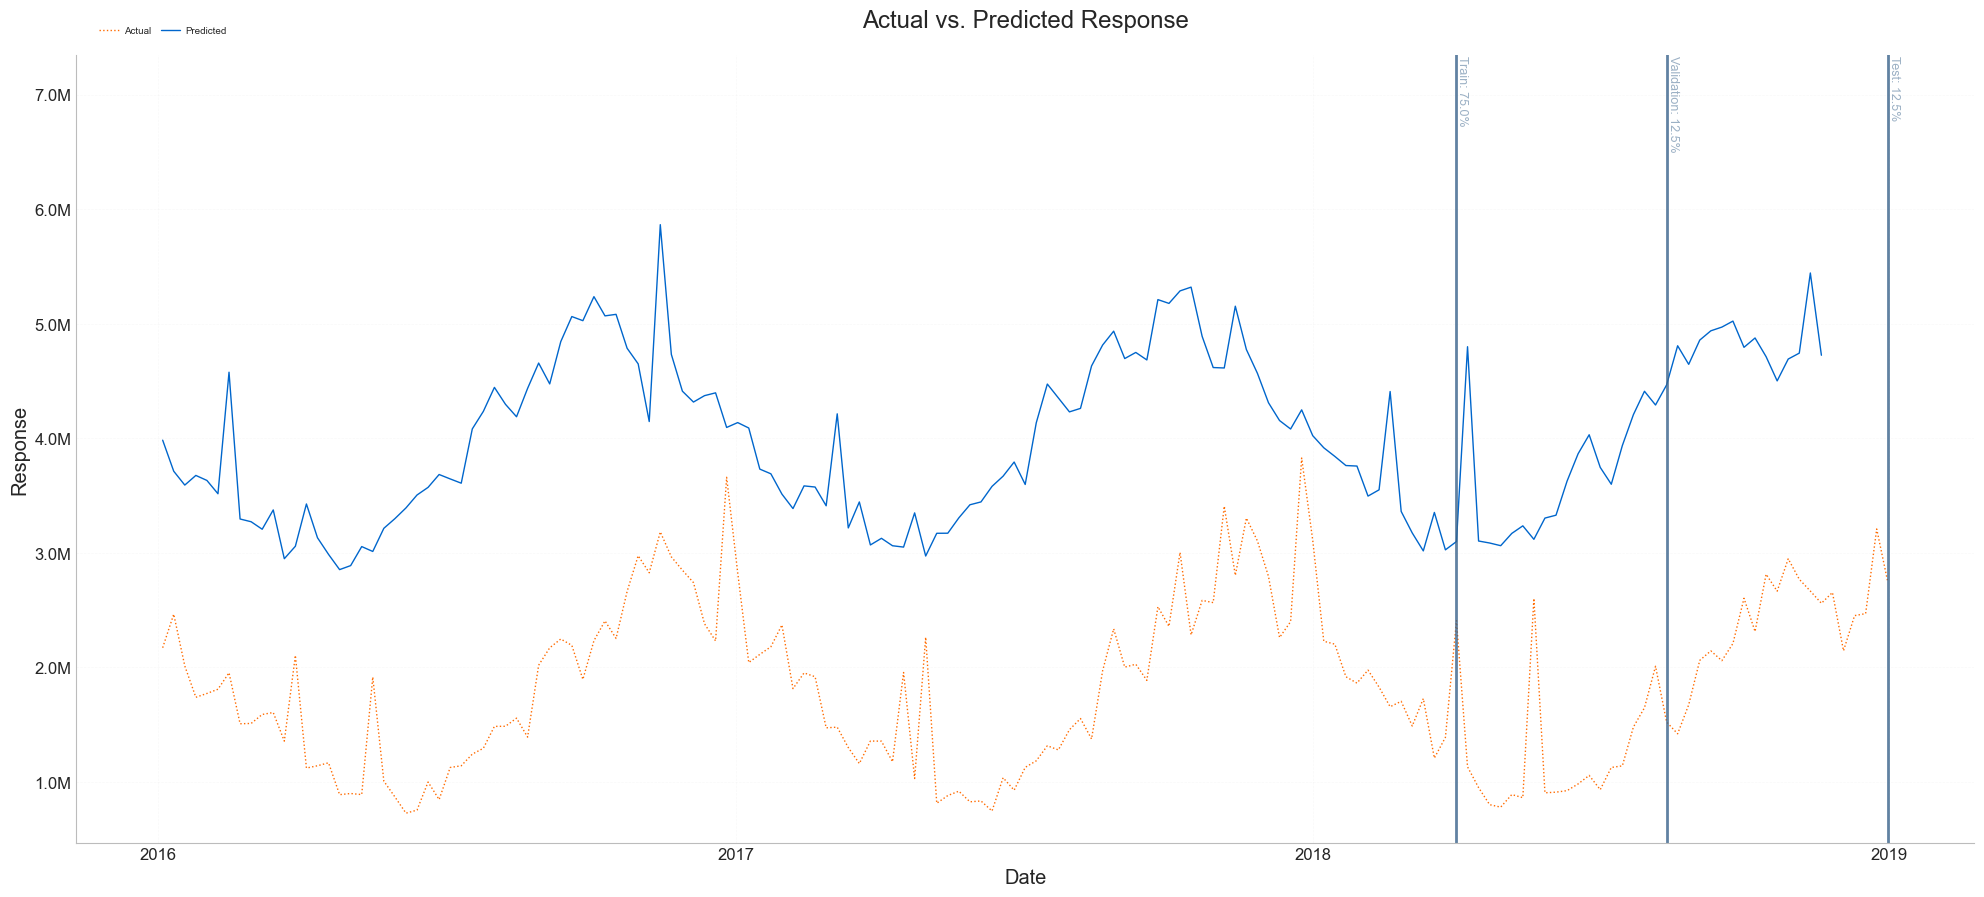

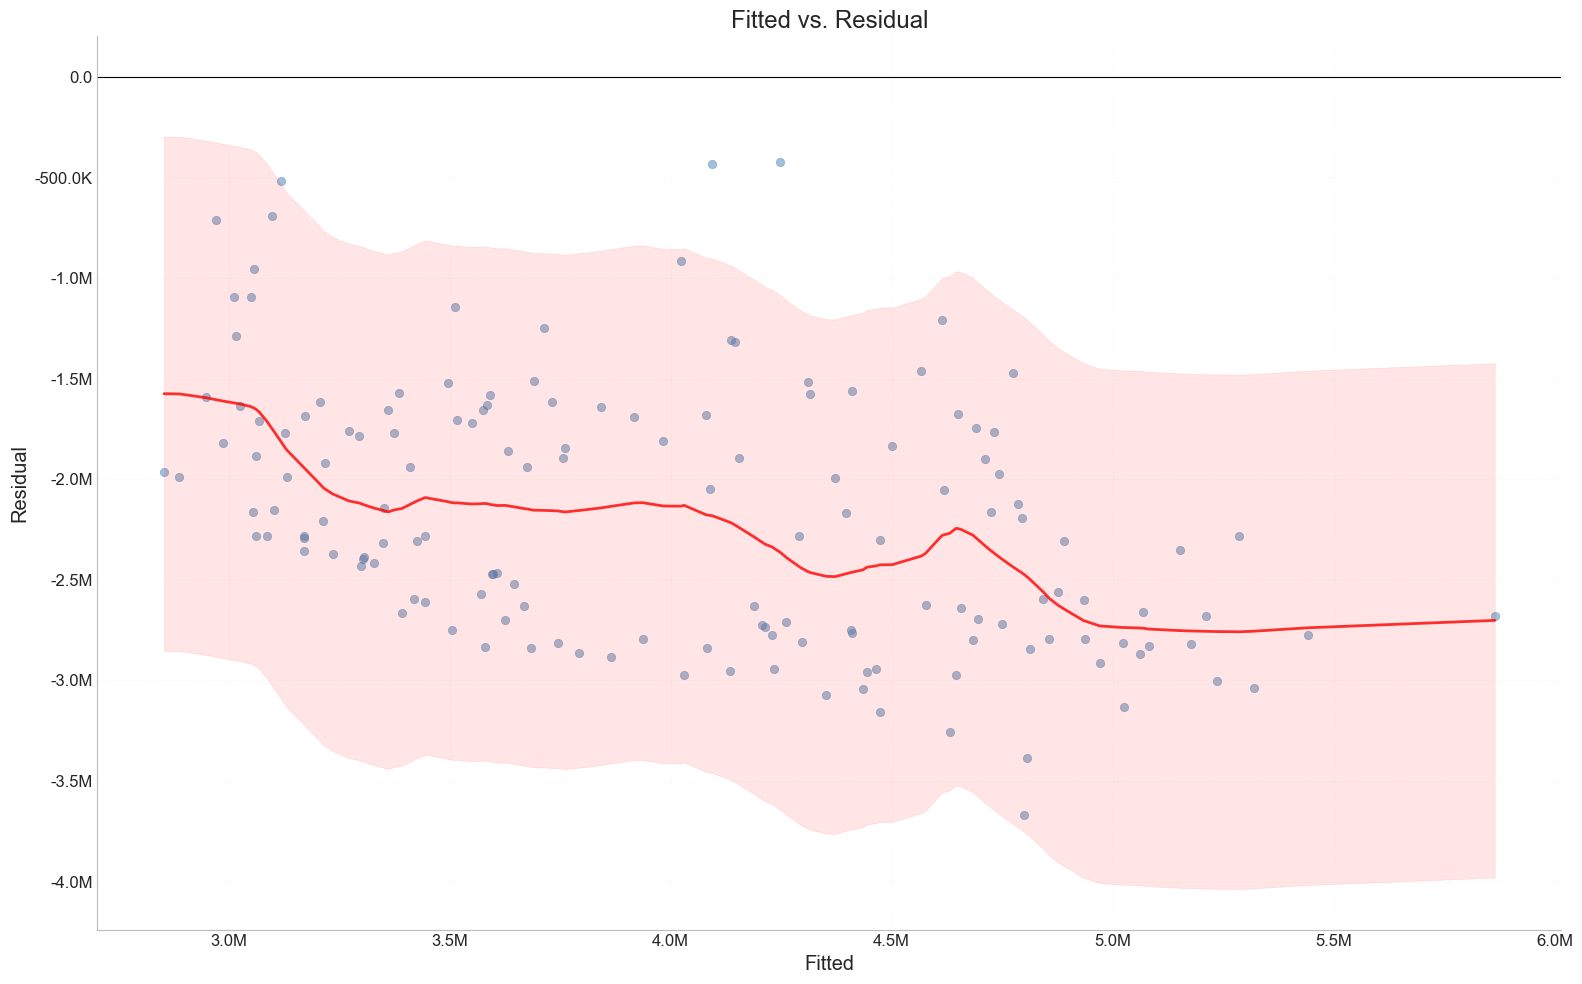

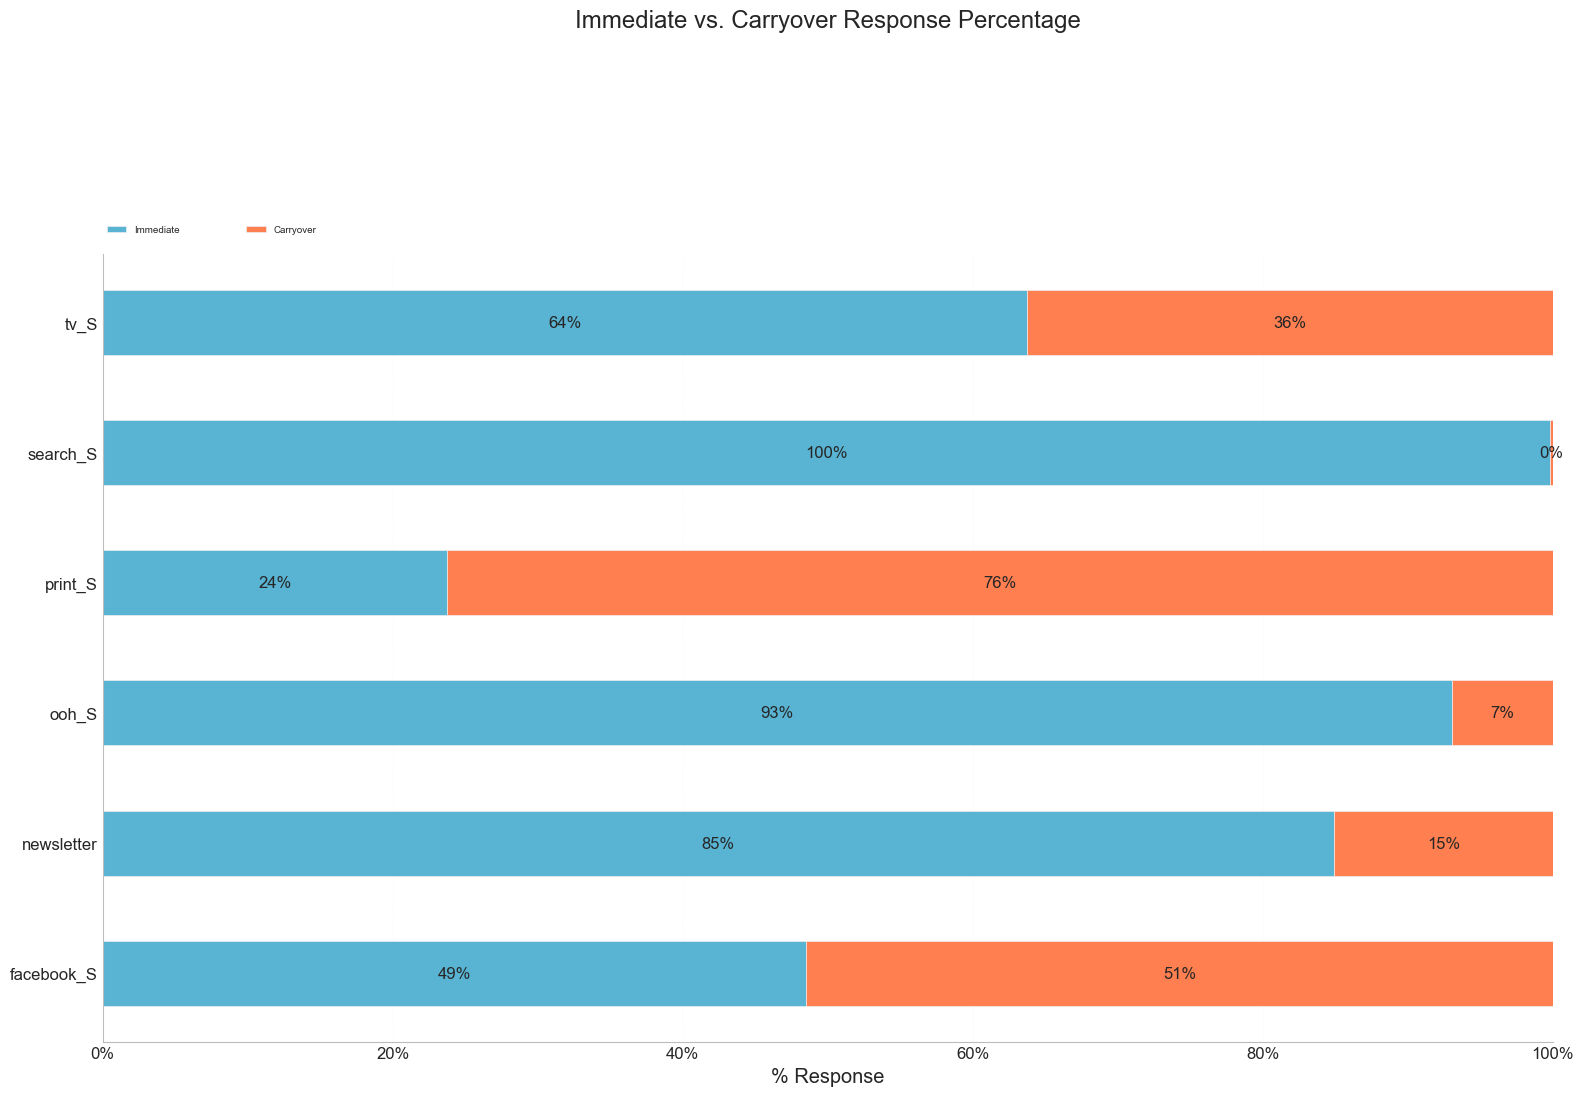

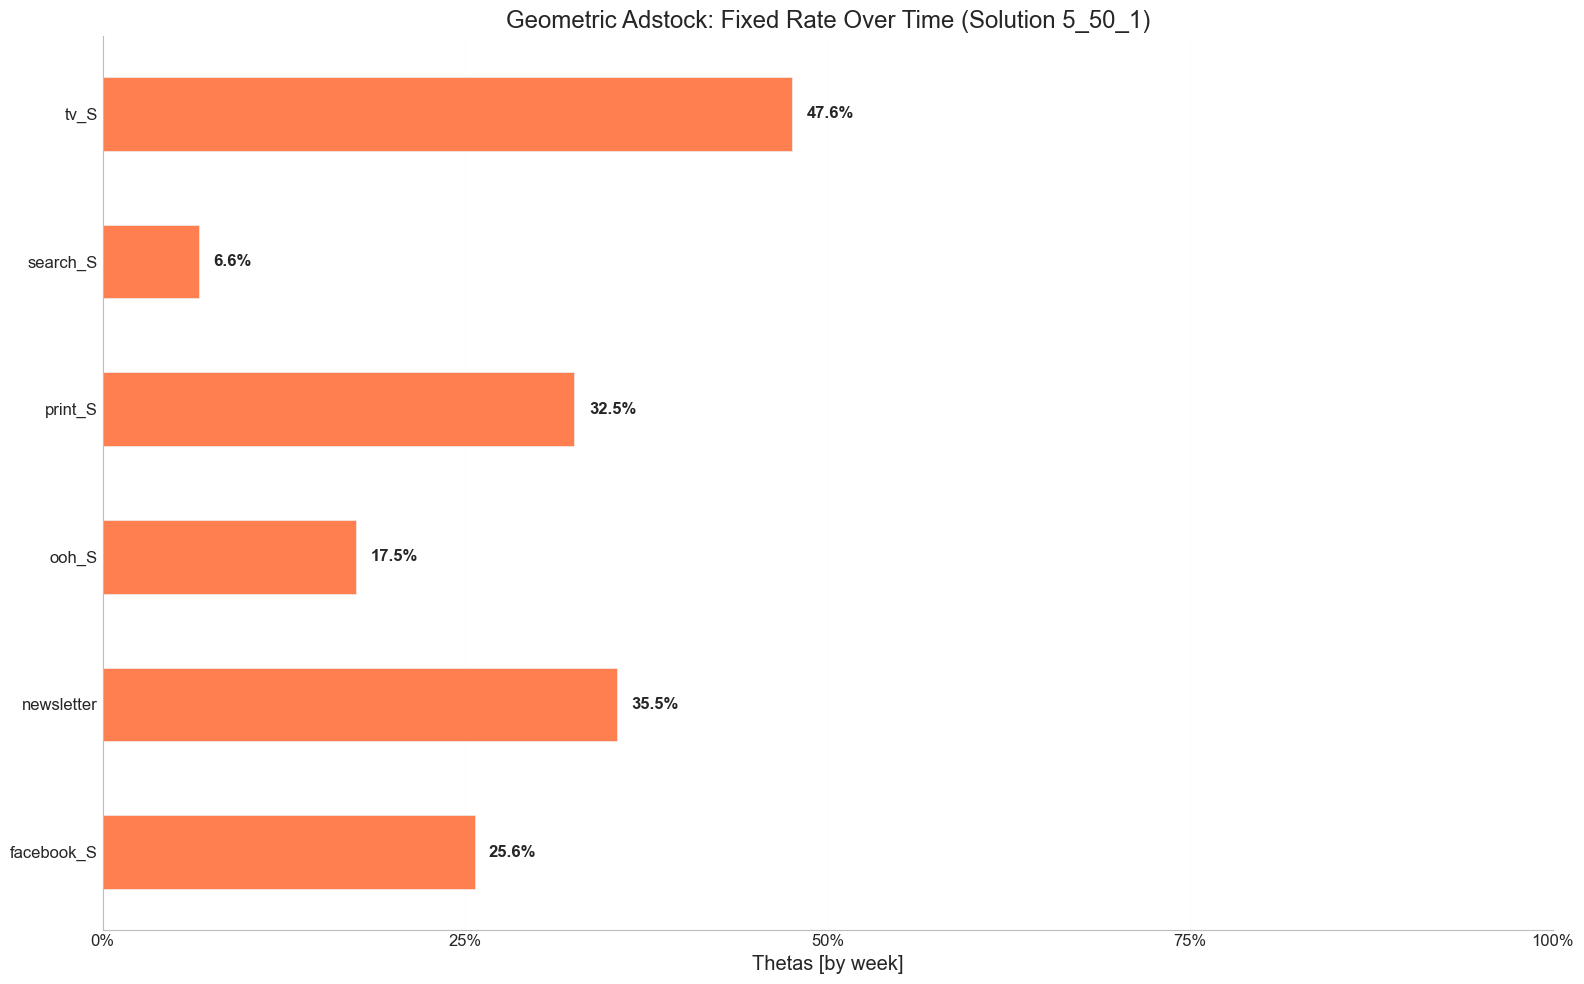

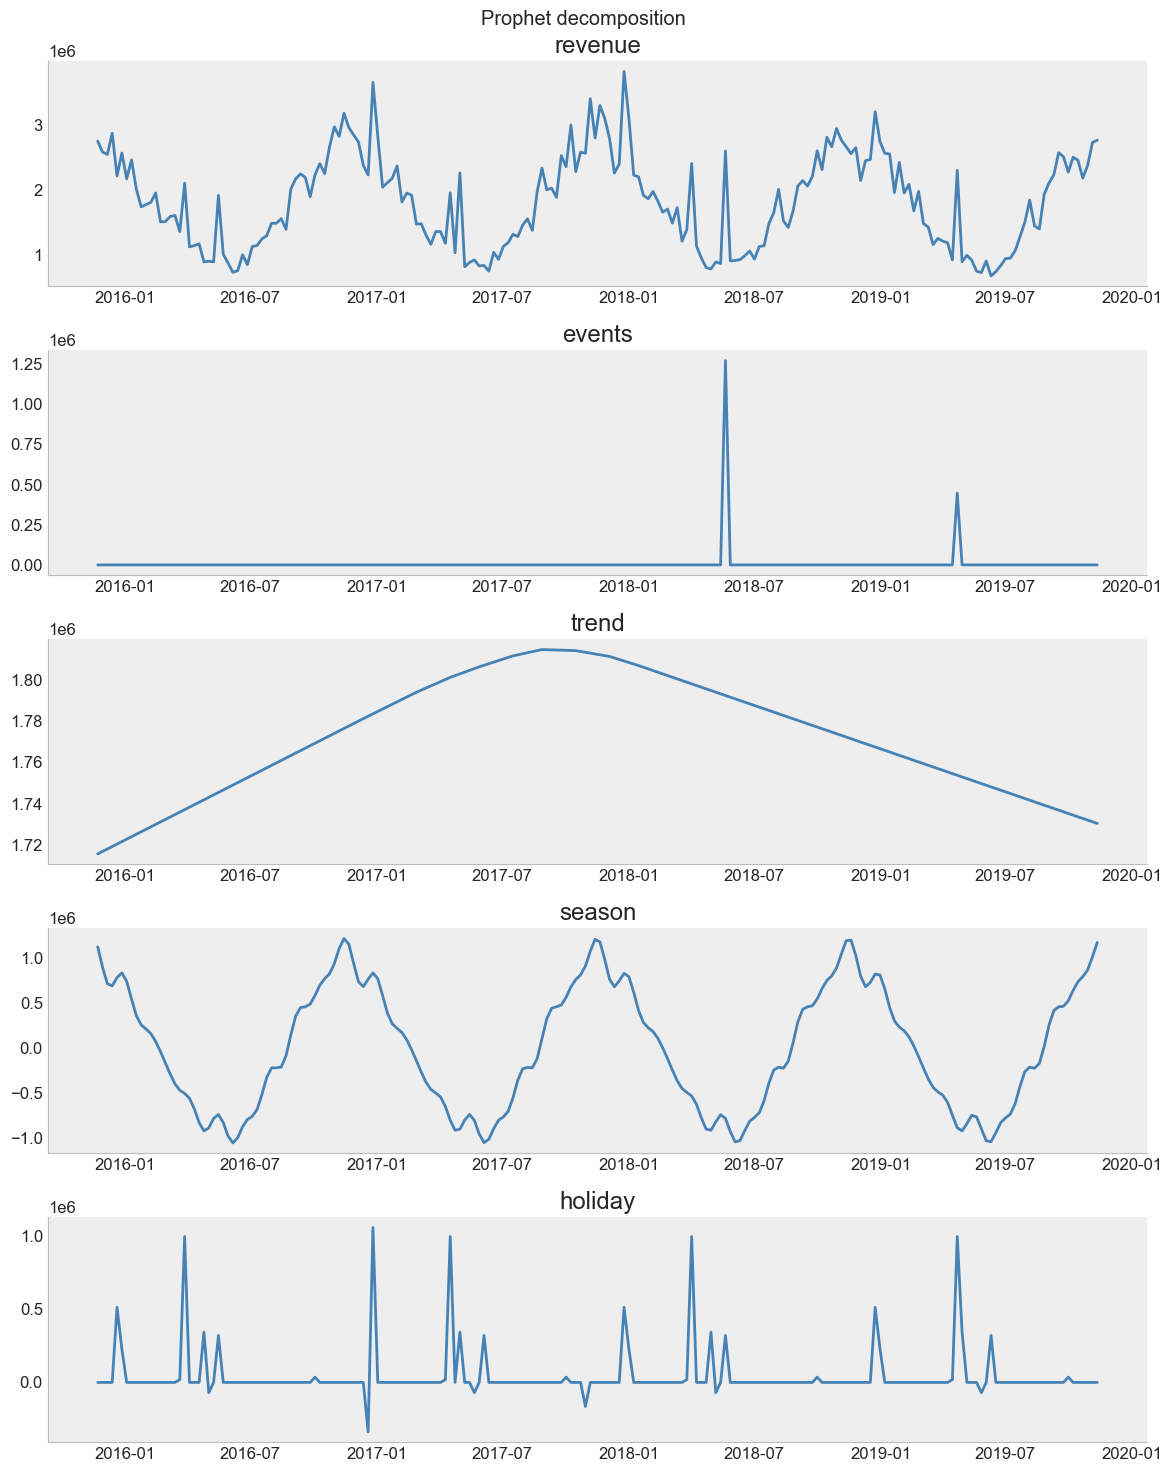

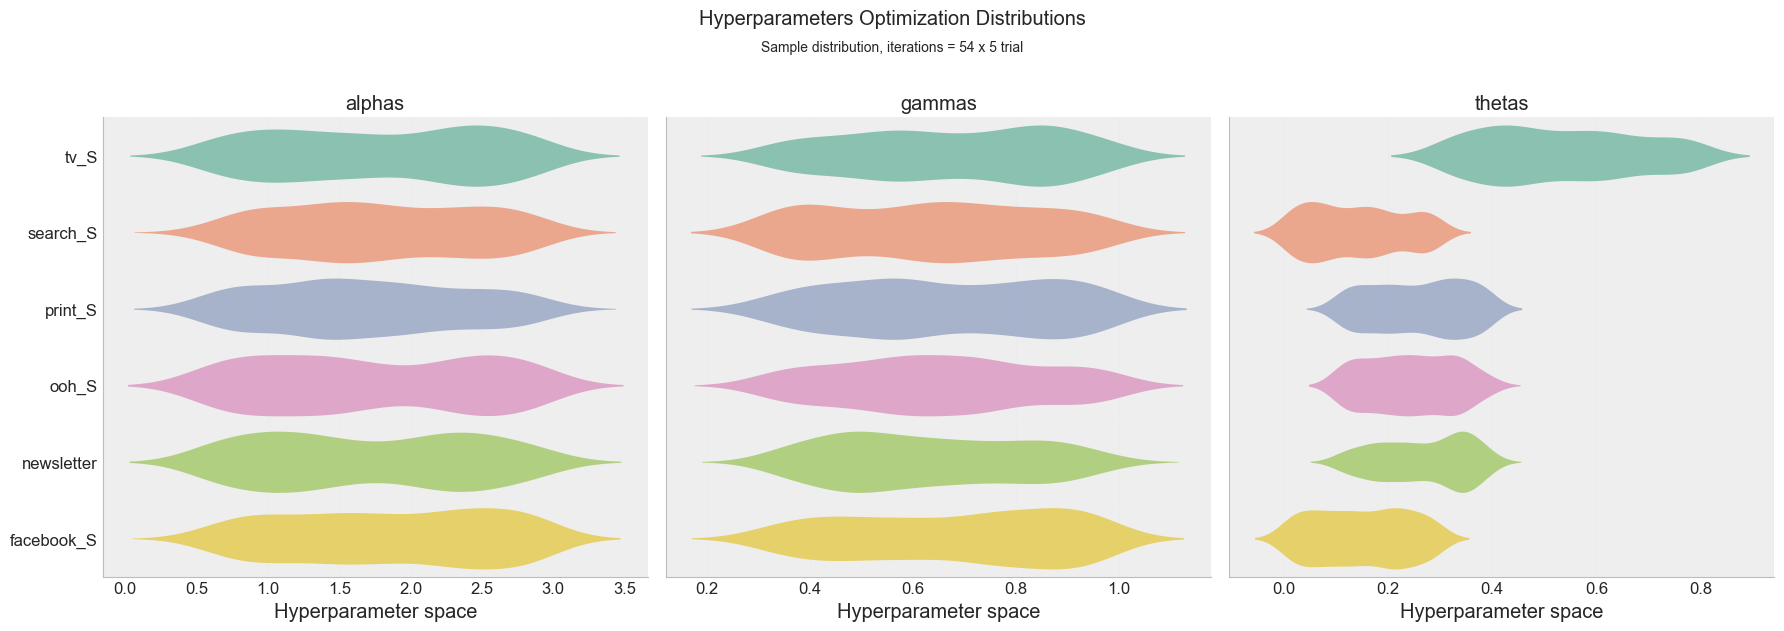

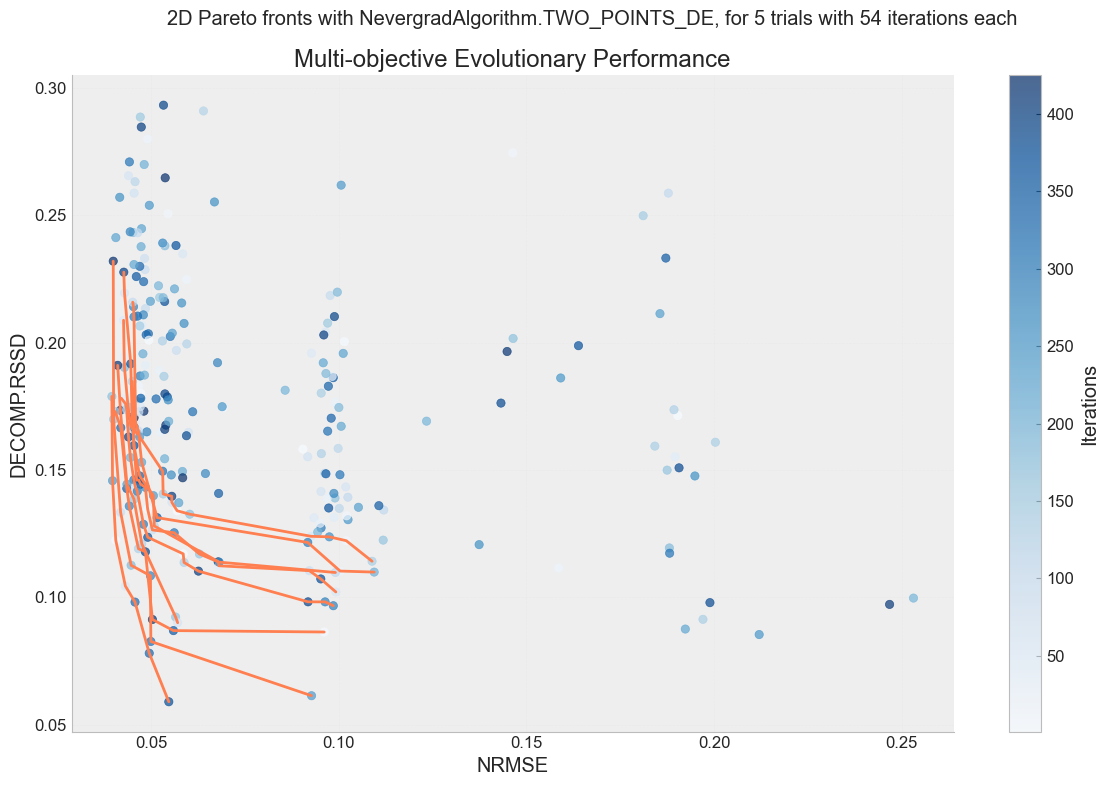

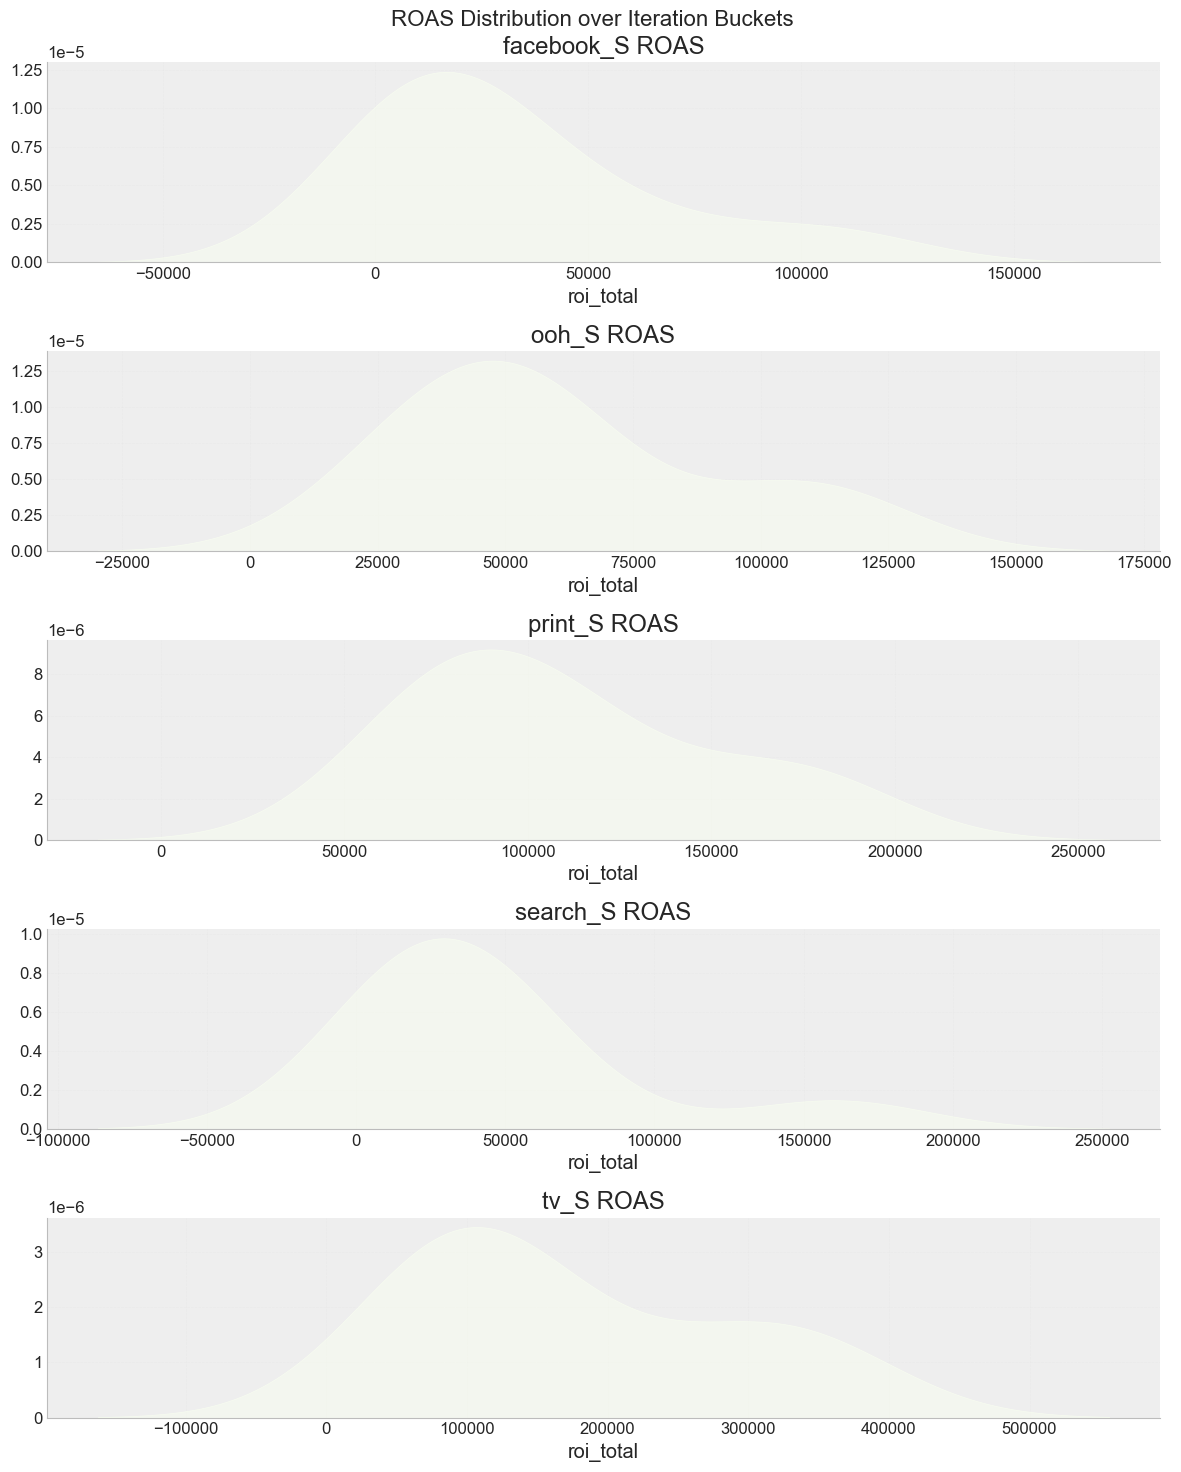

2024-12-06 19:26:09,379 - robyn.visualization.base_visualizer - INFO - Initializing BaseVisualizer with style: bmh
2024-12-06 19:26:09,380 - robyn.visualization.base_visualizer - INFO - BaseVisualizer initialization completed
2024-12-06 19:26:09,380 - robyn.visualization.cluster_visualizer - WARNING - create_correlations_heatmap method is not implemented.


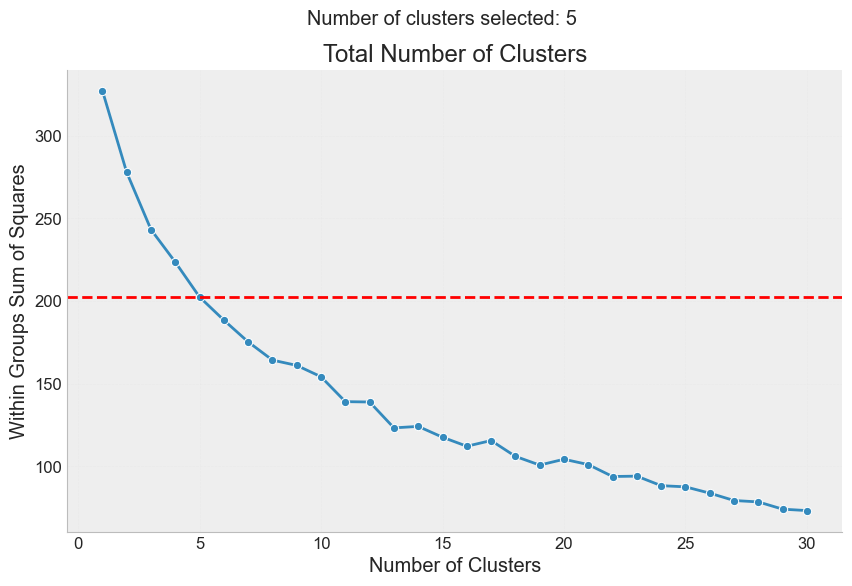

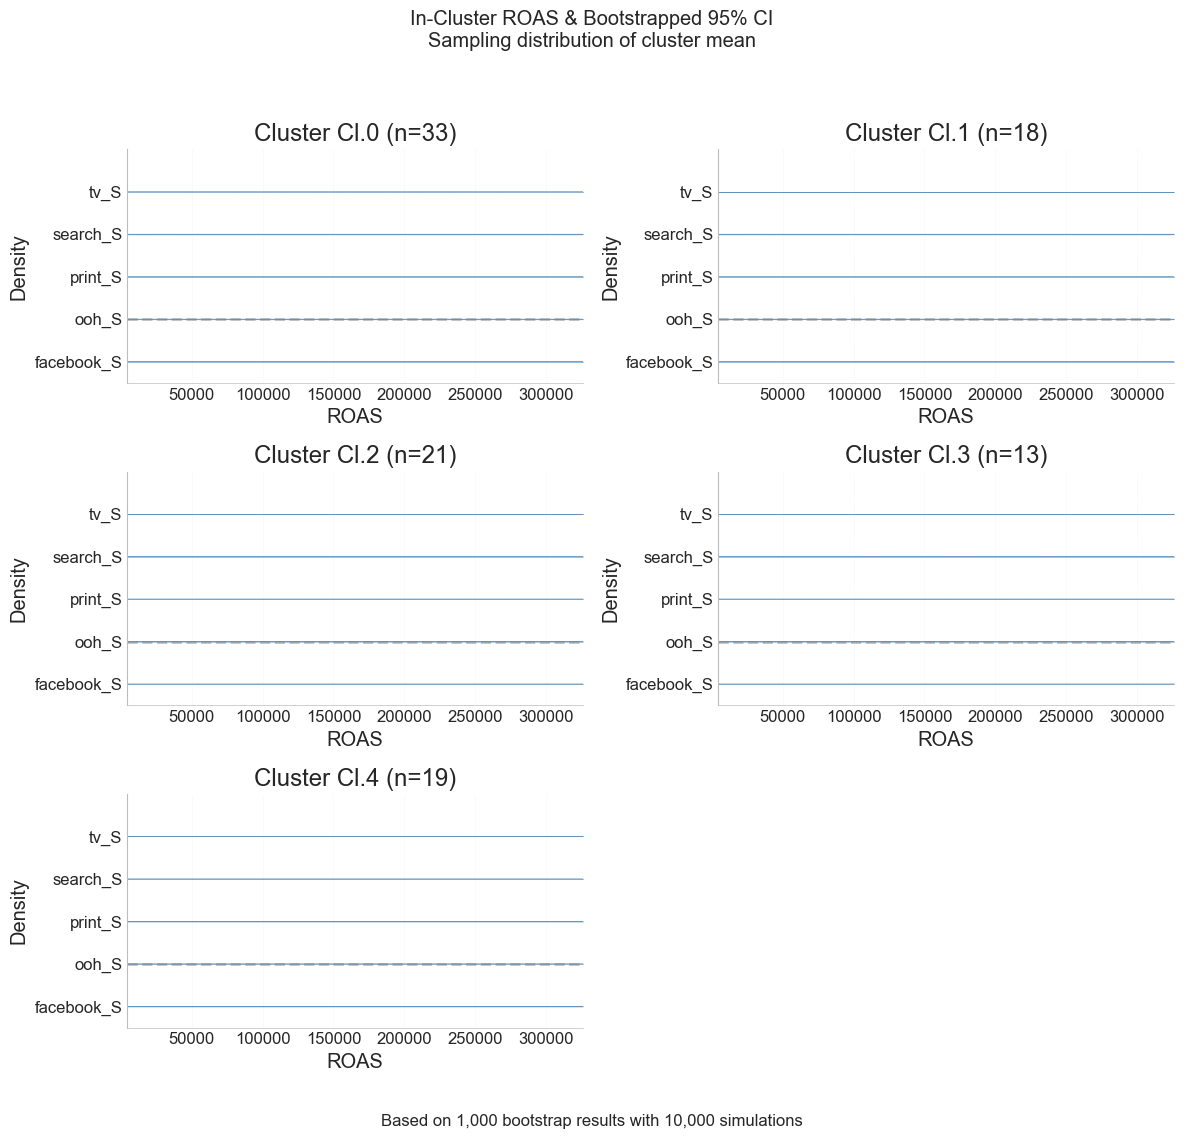

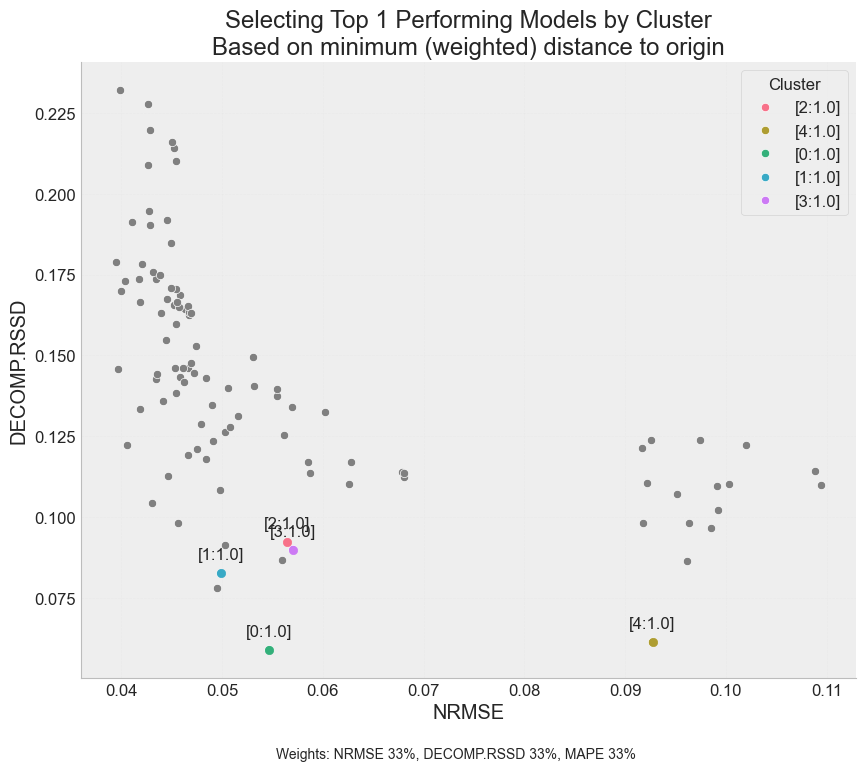

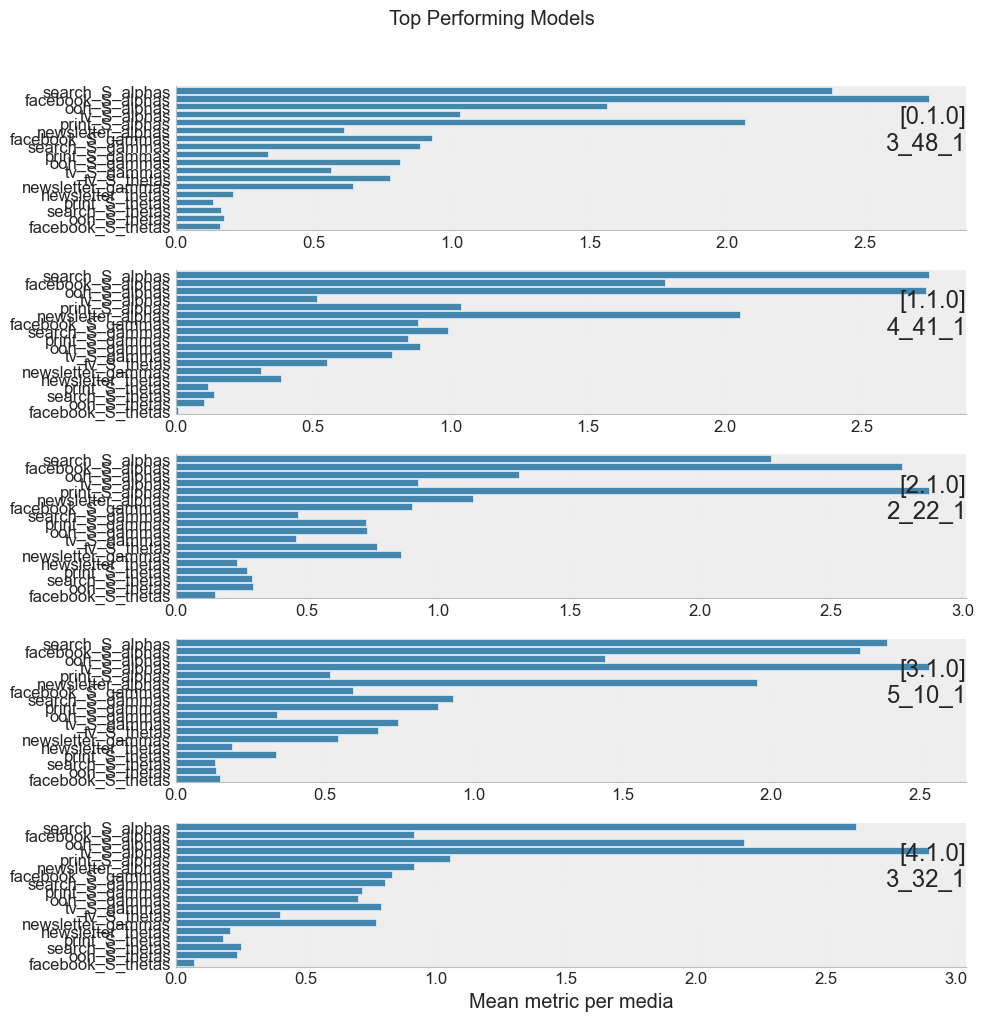

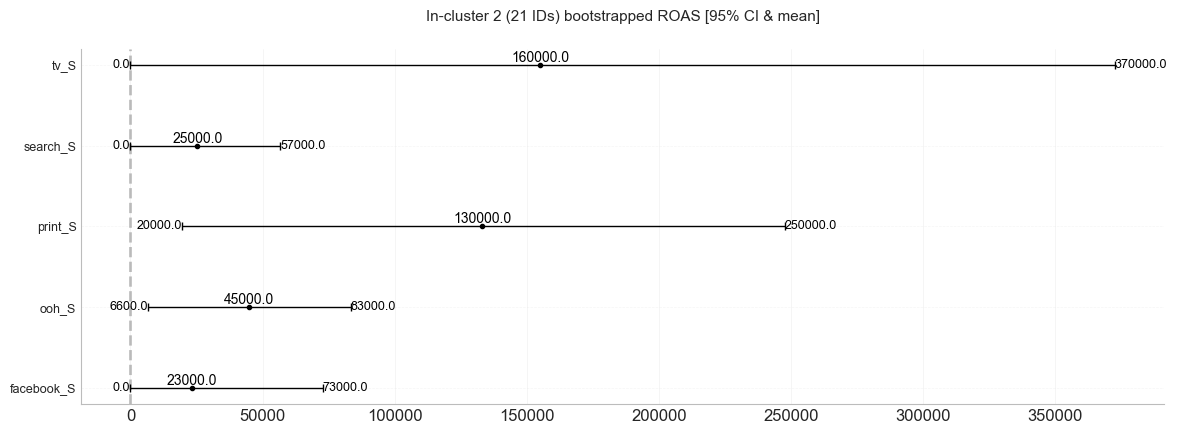

INFO: Model evaluation complete
2024-12-06 19:26:10,408 - robyn.robyn - INFO - Model evaluation complete


In [9]:
from robyn.modeling.clustering.clustering_config import ClusterBy, ClusteringConfig

configs = ClusteringConfig(
    dep_var_type=DependentVarType(mmm_data.mmmdata_spec.dep_var_type),
    cluster_by=ClusterBy.HYPERPARAMETERS,
    max_clusters=10,
    min_clusters=3,
    weights=[1.0, 1.0, 1.0],
)

robyn.evaluate_models(cluster_config=configs)

## Generate One-Pager Report

The one-pager report provides a comprehensive visualization of your model's results through 8 key plots:

1. **Share of Total Spend, Effect & Performance**
  - Compares media channel spend shares vs their effectiveness
  - Shows ROI/CPA performance by channel

2. **Response Decomposition Waterfall**
  - Breaks down total response into channel contributions
  - Shows base, incremental, and total effects

3. **Actual vs. Predicted Response**
  - Plots actual vs model-predicted values
  - Helps validate model fit quality

4. **Fitted vs. Residual Plot**
  - Diagnostic plot showing model residuals
  - Helps check model assumptions

5. **Immediate vs. Carryover Response**
  - Shows split between immediate and carryover effects
  - Reveals lag effects by channel

6. **Adstock Rate Analysis**
  - Visualizes decay rates by channel
  - Shows how media effects persist over time

7. **Bootstrapped Performance Metrics**
  - Confidence intervals for model metrics
  - Shows model stability

8. **Response Curves by Channel**
  - Shows diminishing returns curves
  - Plots response vs spend by channel

In [10]:
robyn.generate_one_pager()

2024-12-06 19:26:10,436 - robyn.visualization.base_visualizer - INFO - Initializing BaseVisualizer with style: bmh
2024-12-06 19:26:10,438 - robyn.visualization.base_visualizer - INFO - BaseVisualizer initialization completed
2024-12-06 19:26:10,440 - robyn.visualization.base_visualizer - INFO - Initializing BaseVisualizer with style: bmh
2024-12-06 19:26:10,441 - robyn.visualization.base_visualizer - INFO - BaseVisualizer initialization completed
2024-12-06 19:26:10,443 - robyn.visualization.base_visualizer - INFO - Initializing BaseVisualizer with style: bmh
2024-12-06 19:26:10,444 - robyn.visualization.base_visualizer - INFO - BaseVisualizer initialization completed
2024-12-06 19:26:10,446 - robyn.visualization.base_visualizer - INFO - Initializing BaseVisualizer with style: bmh
2024-12-06 19:26:10,446 - robyn.visualization.base_visualizer - INFO - BaseVisualizer initialization completed
2024-12-06 19:26:10,646 - robyn.visualization.base_visualizer - INFO - Initializing BaseVisualiz

In [11]:
# robyn.generate_one_pager(solution_id="1_1994_1")

## Budget Allocation Optimization

Robyn provides different scenarios for budget allocation optimization. Let's explore the "max_response" scenario:

### Scenario: Maximum Response
This scenario answers the question: "What's the maximum return given certain spend constraints?"

Key parameters:
- `total_budget`: When set to None, uses the total spend in the selected date range
- `channel_constr_low`: Minimum spend multiplier (e.g., 0.7 means channel spend can't go below 70% of current)
- `channel_constr_up`: Maximum spend multiplier per channel (e.g., 1.5 means channel spend can't exceed 150% of current)
- `channel_constr_multiplier`: Extends bounds for wider optimization insights
- `date_range`: Period for optimization ("all", "last_X", or specific date range)

Note: Other scenarios include:
- "target_efficiency": Optimize spend to hit specific ROAS or CPA targets
- "min_spend": Find minimum spend required to hit response targets
- "max_response_expected": Maximize expected response within confidence intervals

For this example, we'll demonstrate the "max_response" scenario:

INFO: Optimizing budget allocation
2024-12-06 19:26:11,231 - robyn.robyn - INFO - Optimizing budget allocation
INFO: Selected model for budget optimization: 5_50_1
2024-12-06 19:26:11,233 - robyn.robyn - INFO - Selected model for budget optimization: 5_50_1
2024-12-06 19:26:11,378 - robyn.visualization.base_visualizer - INFO - Initializing BaseVisualizer with style: bmh
2024-12-06 19:26:11,379 - robyn.visualization.base_visualizer - INFO - BaseVisualizer initialization completed
2024-12-06 19:26:11,379 - robyn.visualization.allocator_visualizer - INFO - Initializing AllocatorPlotter
2024-12-06 19:26:11,379 - robyn.visualization.allocator_visualizer - INFO - Creating all plots for model 5_50_1
2024-12-06 19:26:11,379 - robyn.visualization.allocator_visualizer - INFO - Creating budget comparison plot
2024-12-06 19:26:11,405 - robyn.visualization.allocator_visualizer - INFO - Creating allocation matrix plot


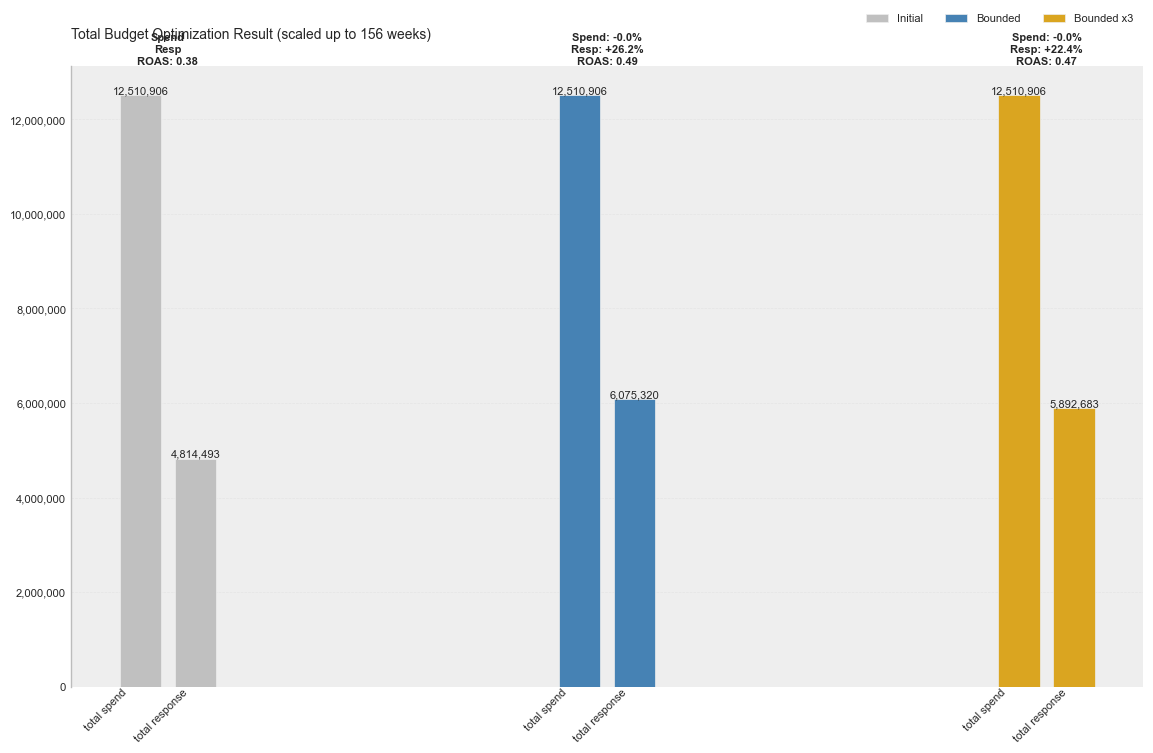

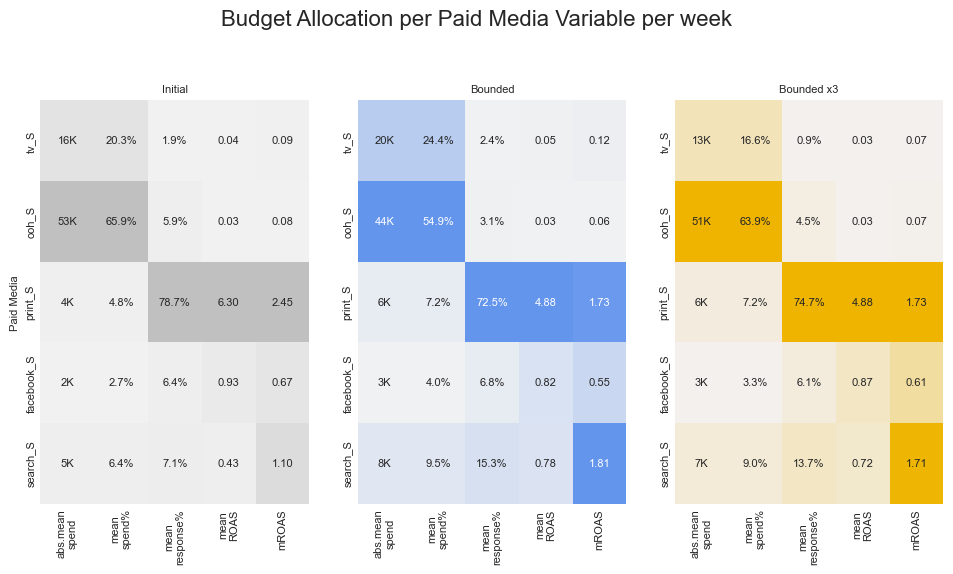

2024-12-06 19:26:11,762 - robyn.visualization.base_visualizer - INFO - Saving multiple plots to: /Users/yijuilee/robynpy_release_reviews/Robyn/python/src/robyn/tutorials/output
2024-12-06 19:26:12,195 - robyn.visualization.base_visualizer - INFO - Plot budget_opt saved successfully
2024-12-06 19:26:12,641 - robyn.visualization.base_visualizer - INFO - Plot allocation saved successfully
INFO: Budget optimization complete
2024-12-06 19:26:12,641 - robyn.robyn - INFO - Budget optimization complete


In [12]:
from robyn.allocator.entities.allocation_params import AllocatorParams
from robyn.allocator.constants import (
    SCENARIO_MAX_RESPONSE,
    CONSTRAINT_MODE_EQ,
)

allocator_params = AllocatorParams(
    scenario=SCENARIO_MAX_RESPONSE,
    total_budget=None,  # Uses total spend in date_range when None
    date_range="all",
    channel_constr_low=[0.7],  # Minimum spend multiplier
    channel_constr_up=[1.2, 1.5, 1.5, 1.5, 1.5],  # Maximum spend multiplier
    channel_constr_multiplier=3.0,
    optim_algo="SLSQP_AUGLAG",
    maxeval=100000,
    constr_mode=CONSTRAINT_MODE_EQ,
    plots=True,
)

allocation_result = robyn.optimize_budget(
    allocator_params=allocator_params,
    select_model=None,
)